# Table of Contents

* [Getting started](#getting_started)
* [Data preprocessing](#preprocessing)
    * [Check for missing values](#imputation)
    * [Check for duplicates](#duplicates)
    * [Check for unique customer identifier](#unique)
    * [Check for outliers](#outliers)
    * [Robust scaler](#standardize)
* [Exploratory data](#EDA)
    * [Data types](#dtypes)
    * [Summary statistics](#summary_stats)
    * [Bootstrapping](#bootstrapping)
    * [Distributions](#distributions)
    * [Spearman correlation](#correlation)
    * [Multiple linear regression](#multiple_linear_regression)
* [Modeling](#modeling)
    * [K-means clustering](#cluster)
        * [Find optimal number of clusters](#elbow)
        * [Cluster customers](#cluster_customers)
    * [SMOTE](#SMOTE)
    * [Model selection](#model_selection)
        * [Decision tree classifier](#decision_tree)
        * [Multinomial logistic regression](#logistic_regression)
    * [Feature importance](#feature_importance)
    * [Visualize decision tree](#visualize)
* [Summarize insights from analysis](#summary)

# Getting started <a class="anchor" id="getting_started"></a>

In [1]:
# Link to dataset
# https://www.kaggle.com/arjunbhasin2013/ccdata?select=CC+GENERAL.csv

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from collections import Counter
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# # Read and preview data
# df = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')
# print(df.shape)
# df.head()

In [4]:
# Read and preview data
df = pd.read_csv('CC GENERAL.csv')
print(df.shape)
df.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
# Description of columns

# CUST_ID : Identification of Credit Card holder (Categorical)
# BALANCE : Balance amount left in their account to make purchases
# BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES : Amount of purchases made from account
# ONEOFF_PURCHASES : Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES : Amount of purchase done in installment
# CASH_ADVANCE : Cash in advance given by the user
# PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY : How frequently the cash in advance being paid
# CASH_ADVANCE_TRX : Number of Transactions made with "Cash in Advanced"
# PURCHASES_TRX : Number of purchase transactions made
# CREDIT_LIMIT : Limit of Credit Card for user
# PAYMENTS : Amount of Payment done by user
# MINIMUM_PAYMENTS : Minimum amount of payments made by user
# PRC_FULL_PAYMENT : Percent of full payment paid by user
# TENURE : Tenure of credit card service for user

In [6]:
# Create a list of all the features
features = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

# Preprocessing <a class="anchor" id="preprocessing"></a>

## Check for missing values <a class="anchor" id="imputation"></a>

In [7]:
# Check for columns with missing values and impute them with the median.
def impute_nan(df):
    """Check for columns with missing values and impute them with the median."""
    nan_cols = df.columns[df.isnull().any()].tolist()
    nan_length = len(nan_cols)
    if nan_length == 0:
        return df
    else:
        print('Imputed features:', nan_cols)
        for x in nan_cols:
            df[x].fillna(df[x].median(), inplace=True)
        return df

df = impute_nan(df)

Imputed features: ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']


## Check for duplicate rows <a class="anchor" id="duplicates"></a>

In [8]:
# Check for duplicates
def duplicates(x):
    """Check for duplicate rows. 
    Either dedupe or return original dataset if there are no duplicate rows."""
    y = x.drop_duplicates()
    duplicate_rows = x.shape[0] - y.shape[0]
    print('Duplicate rows:', duplicate_rows)
    if duplicate_rows == 0:
        return x
    else:
        return y

df = duplicates(df)

Duplicate rows: 0


## Check for unique customer identifier <a class="anchor" id="unique"></a>

In [9]:
custs = df.CUST_ID.nunique()
rows = df.shape[0]

if custs == rows:
    print('CUST_ID is unique')
else:
    print('Need to create a unique identifier')

CUST_ID is unique


## Check for outliers <a class="anchor" id="outliers"></a>

In [10]:
def outliers(df, features):
    """Count the number of outliers for each feature using the IQR"""
    num_outliers = []
    pct_outliers = []
    total_rows = []
    interquartile_range = []
    for i in features:
        Q1 = df[i].quantile(.25)
        Q3 = df[i].quantile(.65)
        IQR = Q3 - Q1
        outliers = len(df[(df[i] < (Q1-1.5*IQR)) | (df[i] > (Q3+1.5*IQR))])
        rows = len(df[i])
        pct = outliers/rows
        interquartile_range.append(IQR)
        num_outliers.append(outliers)
        pct_outliers.append(pct)
        total_rows.append(rows)
        
    count_outliers = pd.DataFrame({'Feature': features
                               , 'Num_Outliers': num_outliers
                                , 'Percent_Outliers': pct_outliers
                                , 'IQR': interquartile_range
                               , 'Total_Rows': total_rows}).sort_values('Percent_Outliers', ascending=False)
    return count_outliers

count_outliers = outliers(df=df, features=features)
count_outliers

,Feature,Num_Outliers,Percent_Outliers,IQR,Total_Rows
15,PRC_FULL_PAYMENT,3047,0.340447,0.000000,8950
5,CASH_ADVANCE,2215,0.247486,451.945519,8950
3,ONEOFF_PURCHASES,2069,0.231173,264.300500,8950
10,CASH_ADVANCE_TRX,1687,0.188492,2.000000,8950
14,MINIMUM_PAYMENTS,1672,0.186816,356.515990,8950
7,ONEOFF_PURCHASES_FREQUENCY,1603,0.179106,0.166667,8950
9,CASH_ADVANCE_FREQUENCY,1558,0.174078,0.125000,8950
4,INSTALLMENTS_PURCHASES,1547,0.172849,284.110500,8950
1,BALANCE_FREQUENCY,1493,0.166816,0.111111,8950
2,PURCHASES,1478,0.165140,664.394000,8950


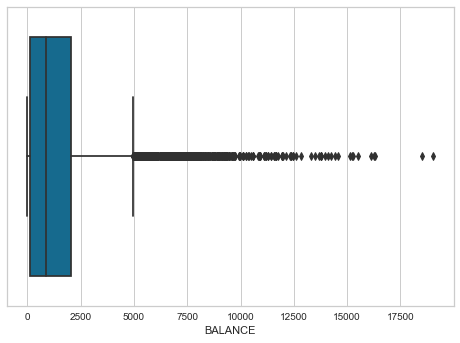

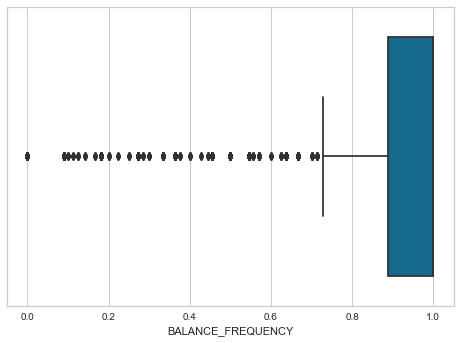

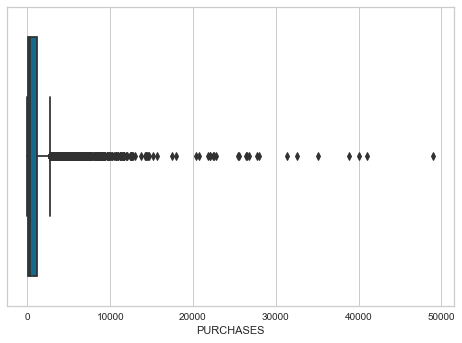

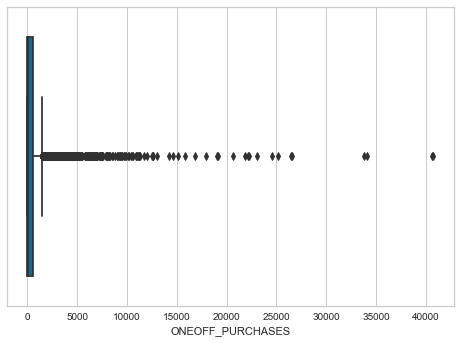

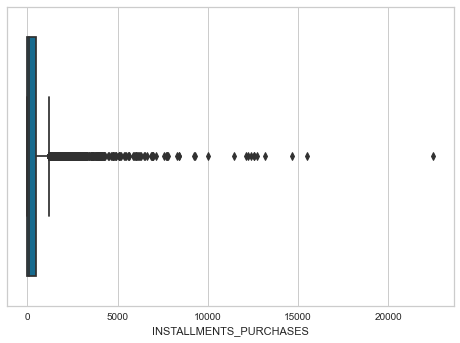

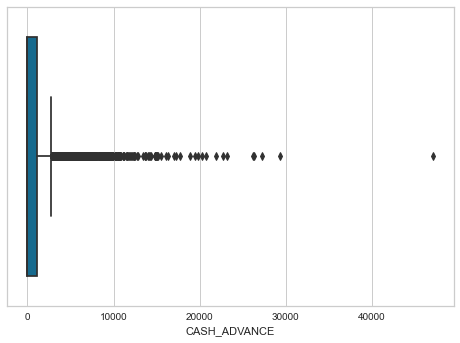

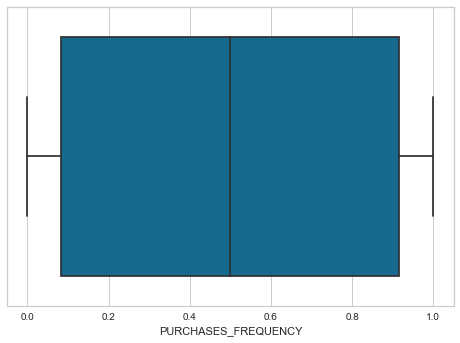

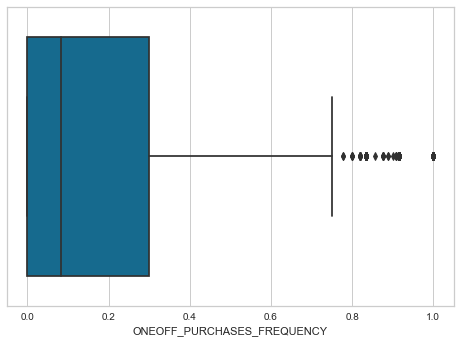

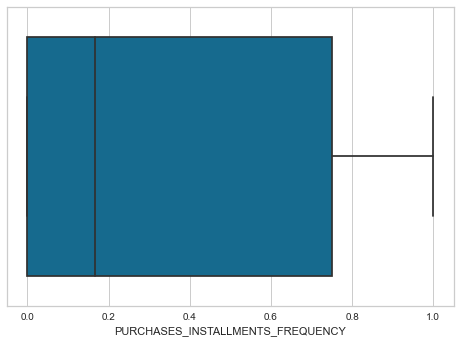

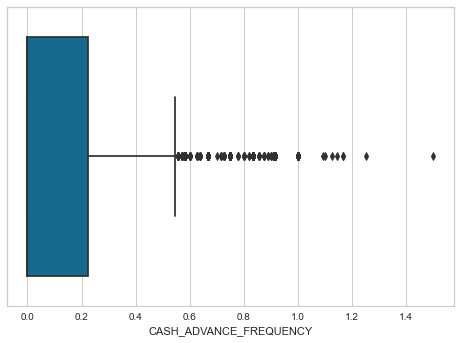

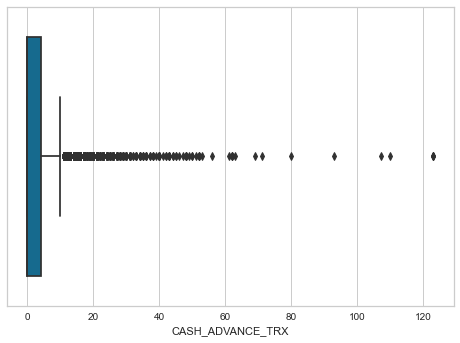

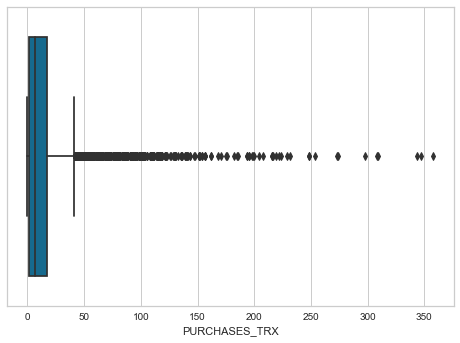

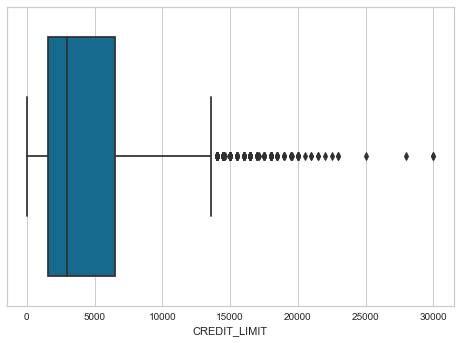

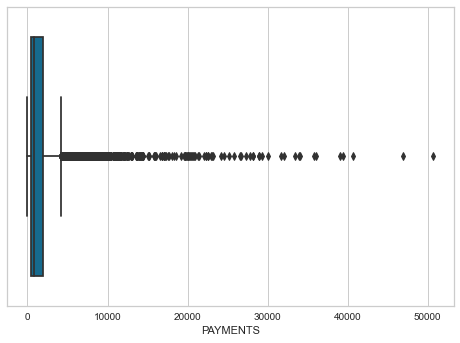

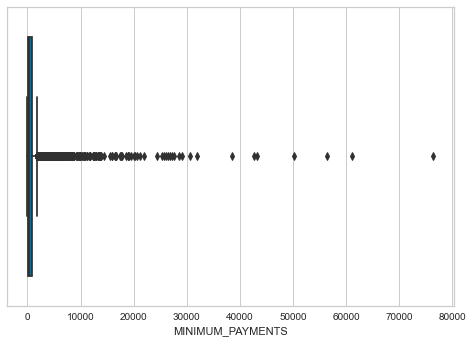

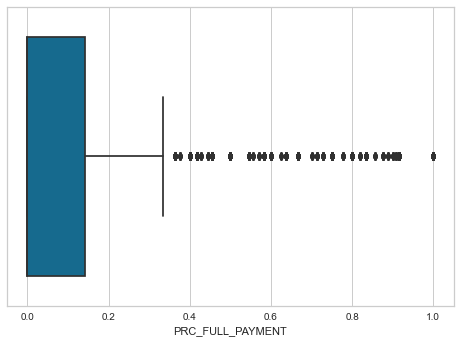

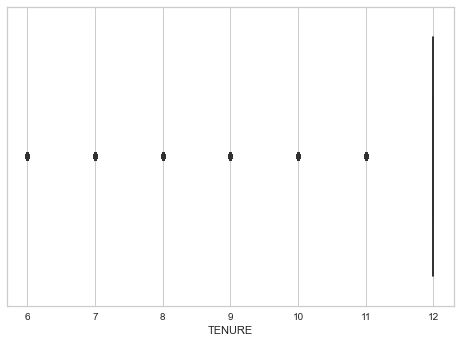

In [11]:
# Visualize outliers with box plots
for i in features:
    sns.boxplot(df[i])
    plt.show()

## Robust scaler <a class="anchor" id="standardize"></a>
    Since most of the features contain a non-trivial amount of outliers, use the robust scaler instead of the standard scaler. The robust scaler uses the median and IQR, which are better estimates of central tendency in the precense of outliers.

In [12]:
# Scale the features
X = df[features]
X_scaled = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns, index=X.index)
df_scaled = pd.concat([df['CUST_ID'], X_scaled], axis=1)

# Exploratory analysis <a class="anchor" id="EDA"></a>

## Data types <a class="anchor" id="dtypes"></a>

In [13]:
df_scaled[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   float64
 11  PURCHASES_TRX                     8950 non-null   float64
 12  CREDIT

## Summary statistics <a class="anchor" id="summary_stats"></a>
    Mean, median, min and max

In [14]:
(df_scaled[features].describe().transpose()
     [['mean', '50%', 'min', 'max']]
     .rename(columns={'50%': 'median'})
     .style.background_gradient(cmap = 'RdYlGn'))

,mean,median,min,max
BALANCE,0.358848,0.000000,-0.453504,9.434627
BALANCE_FREQUENCY,-1.104565,0.000000,-9.000009,0.000000
PURCHASES,0.599652,0.000000,-0.337489,45.472693
ONEOFF_PURCHASES,0.960223,0.000000,-0.065812,70.528052
INSTALLMENTS_PURCHASES,0.687243,0.000000,-0.189912,47.821611
CASH_ADVANCE,0.878840,0.000000,0.000000,42.320270
PURCHASES_FREQUENCY,-0.011579,0.000000,-0.600000,0.600000
ONEOFF_PURCHASES_FREQUENCY,0.397082,0.000000,-0.277777,3.055557
PURCHASES_INSTALLMENTS_FREQUENCY,0.263694,0.000000,-0.222223,1.111111
CASH_ADVANCE_FREQUENCY,0.608150,0.000000,0.000000,6.750007


## Bootstrapping <a class="anchor" id="bootstrapping"></a>
    Estiamte the population mean for each feature with bootstrap sampling.

In [15]:
# Bootstrap sampling
samples = 1000
est_popu_means = {}
boot = []
for a in features:
    for b in range(samples):
        c = df[a].sample(frac = 0.33, random_state = 1).mean()
        boot.append(c)
    p_mean = sum(boot)/len(boot)
    est_popu_means[a] = p_mean
    boot.clear()

# Mean of each feature in the dataset
sampling_mean = []
for i in features:
    x = df[i].mean()
    sampling_mean.append(x)

df_means = pd.DataFrame({'Feature': list(est_popu_means.keys())
                       , 'Bootstrap_Mean': list(est_popu_means.values())
                       , 'Mean_in_dataset': sampling_mean})

df_means

,Feature,Bootstrap_Mean,Mean_in_dataset
0,BALANCE,1544.925802,1564.474828
1,BALANCE_FREQUENCY,0.880153,0.877271
2,PURCHASES,1029.234242,1003.204834
3,ONEOFF_PURCHASES,614.426114,592.437371
4,INSTALLMENTS_PURCHASES,414.974506,411.067645
5,CASH_ADVANCE,939.023397,978.871112
6,PURCHASES_FREQUENCY,0.496370,0.490351
7,ONEOFF_PURCHASES_FREQUENCY,0.198057,0.202458
8,PURCHASES_INSTALLMENTS_FREQUENCY,0.370166,0.364437
9,CASH_ADVANCE_FREQUENCY,0.132016,0.135144


## Distributions <a class="anchor" id="distributions"></a>
    Plot the distribution of each feature with its estimate population mean from the bootstrap sampling.

BALANCE
Bootstrap mean: 1544.9258020701031


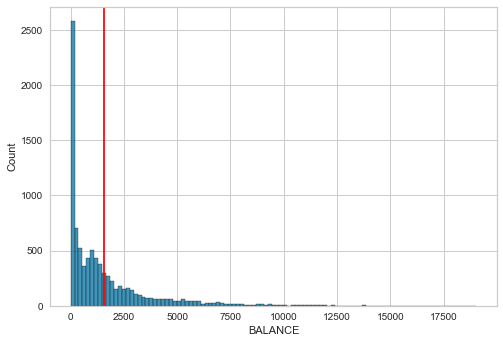

BALANCE_FREQUENCY
Bootstrap mean: 0.8801531983750713


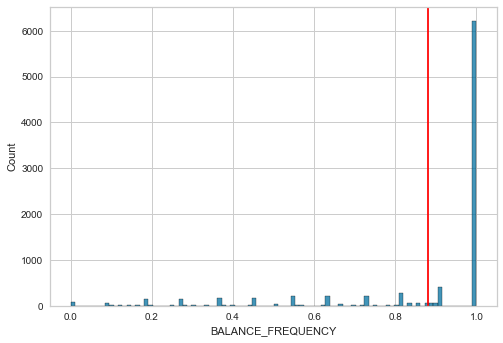

PURCHASES
Bootstrap mean: 1029.2342417061786


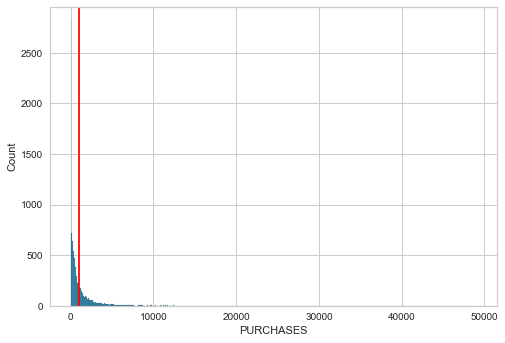

ONEOFF_PURCHASES
Bootstrap mean: 614.4261137440739


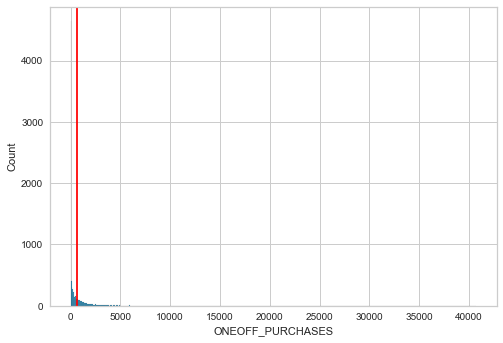

INSTALLMENTS_PURCHASES
Bootstrap mean: 414.9745057549034


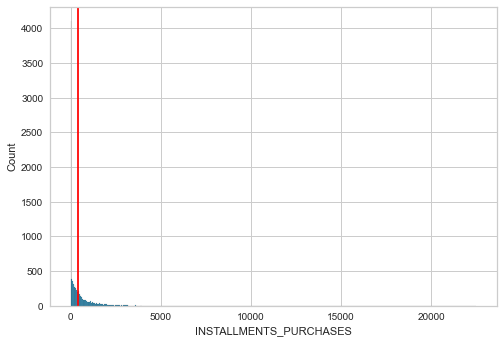

CASH_ADVANCE
Bootstrap mean: 939.0233965822522


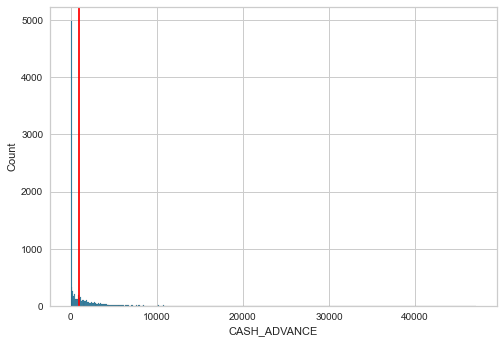

PURCHASES_FREQUENCY
Bootstrap mean: 0.49637017907922376


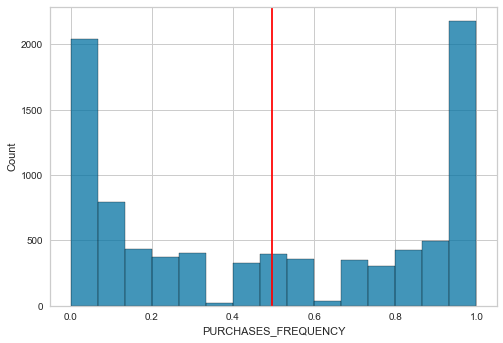

ONEOFF_PURCHASES_FREQUENCY
Bootstrap mean: 0.19805704468517665


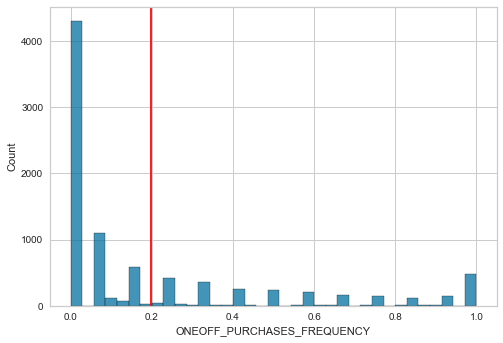

PURCHASES_INSTALLMENTS_FREQUENCY
Bootstrap mean: 0.3701661641841642


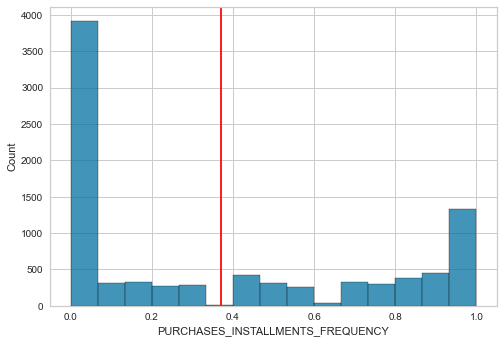

CASH_ADVANCE_FREQUENCY
Bootstrap mean: 0.13201607278266547


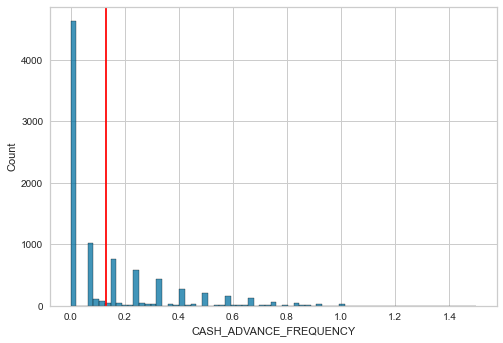

CASH_ADVANCE_TRX
Bootstrap mean: 3.113067027758926


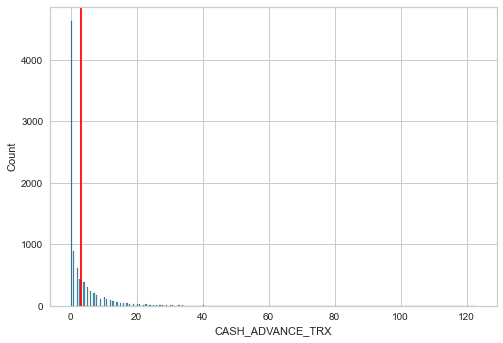

PURCHASES_TRX
Bootstrap mean: 14.807718348002306


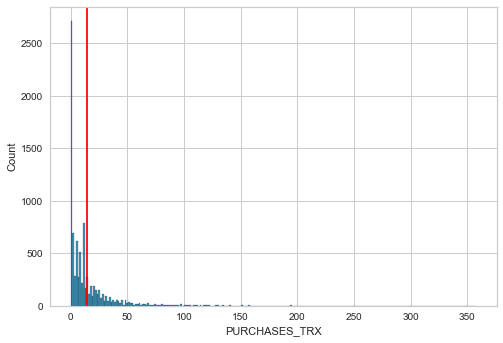

CREDIT_LIMIT
Bootstrap mean: 4538.437523508847


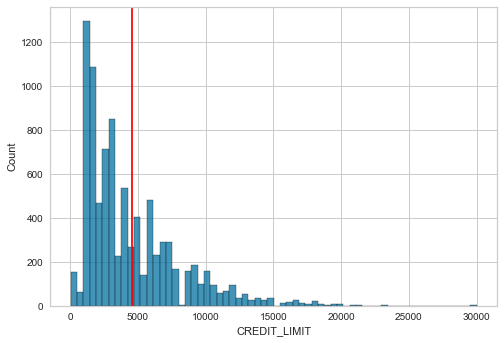

PAYMENTS
Bootstrap mean: 1742.0113839796502


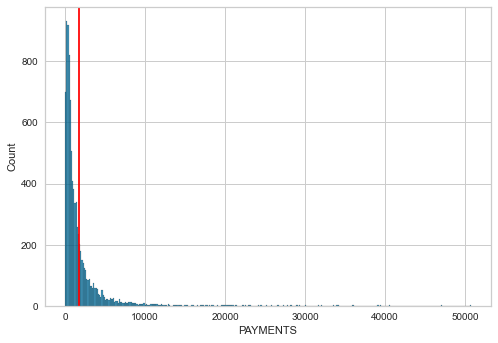

MINIMUM_PAYMENTS
Bootstrap mean: 887.718778012875


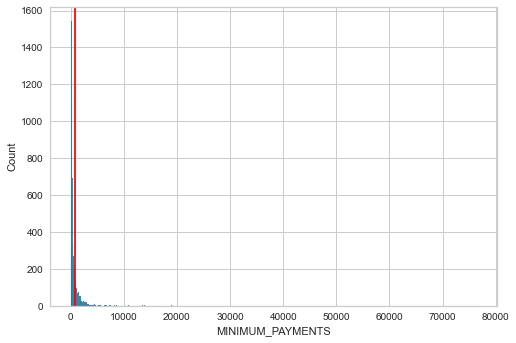

PRC_FULL_PAYMENT
Bootstrap mean: 0.16276787542315654


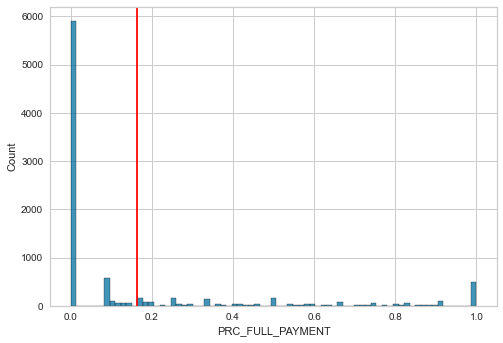

TENURE
Bootstrap mean: 11.515910629654666


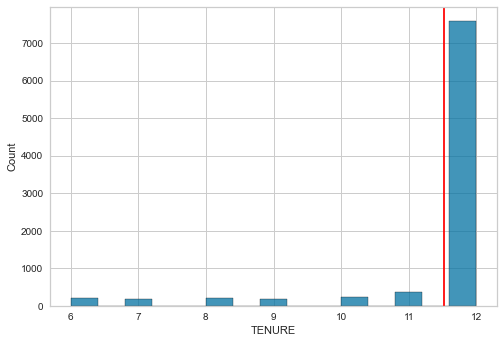

In [16]:
for i in features:
    boot_mean = df_means.loc[df_means['Feature'] == i, 'Bootstrap_Mean'].iloc[0]
    print(i)
    print('Bootstrap mean:', boot_mean)
    sns.histplot(df[i])
    plt.axvline(boot_mean, color = 'red')
    plt.show()

## Spearman correlation <a class="anchor" id="correlation"></a>
    Use the spearman correlation since the features are not normally distributed.

In [17]:
spearman_corr = round(df_scaled[features].corr(method = 'spearman'), 2)
spearman_corr.style.background_gradient(cmap = 'RdYlGn')

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.000000,0.540000,0.010000,0.150000,-0.090000,0.570000,-0.150000,0.120000,-0.140000,0.540000,0.550000,-0.050000,0.370000,0.430000,0.870000,-0.480000,0.070000
BALANCE_FREQUENCY,0.540000,1.000000,0.150000,0.130000,0.130000,0.140000,0.200000,0.160000,0.150000,0.180000,0.180000,0.200000,0.110000,0.210000,0.470000,-0.170000,0.230000
PURCHASES,0.010000,0.150000,1.000000,0.750000,0.710000,-0.380000,0.790000,0.690000,0.610000,-0.390000,-0.380000,0.890000,0.260000,0.390000,-0.010000,0.240000,0.130000
ONEOFF_PURCHASES,0.150000,0.130000,0.750000,1.000000,0.200000,-0.180000,0.420000,0.950000,0.120000,-0.180000,-0.180000,0.590000,0.300000,0.360000,0.070000,0.050000,0.100000
INSTALLMENTS_PURCHASES,-0.090000,0.130000,0.710000,0.200000,1.000000,-0.360000,0.790000,0.190000,0.920000,-0.370000,-0.360000,0.780000,0.120000,0.240000,-0.060000,0.280000,0.120000
CASH_ADVANCE,0.570000,0.140000,-0.380000,-0.180000,-0.360000,1.000000,-0.450000,-0.190000,-0.380000,0.940000,0.950000,-0.410000,0.160000,0.260000,0.480000,-0.270000,-0.110000
PURCHASES_FREQUENCY,-0.150000,0.200000,0.790000,0.420000,0.790000,-0.450000,1.000000,0.460000,0.850000,-0.450000,-0.450000,0.920000,0.100000,0.170000,-0.110000,0.290000,0.100000
ONEOFF_PURCHASES_FREQUENCY,0.120000,0.160000,0.690000,0.950000,0.190000,-0.190000,0.460000,1.000000,0.110000,-0.180000,-0.170000,0.610000,0.280000,0.320000,0.050000,0.060000,0.080000
PURCHASES_INSTALLMENTS_FREQUENCY,-0.140000,0.150000,0.610000,0.120000,0.920000,-0.380000,0.850000,0.110000,1.000000,-0.380000,-0.370000,0.780000,0.050000,0.120000,-0.090000,0.260000,0.110000
CASH_ADVANCE_FREQUENCY,0.540000,0.180000,-0.390000,-0.180000,-0.370000,0.940000,-0.450000,-0.180000,-0.380000,1.000000,0.980000,-0.410000,0.090000,0.200000,0.450000,-0.290000,-0.130000


## Multiple linear regression <a class="anchor" id="multiple_linear_regression"></a>

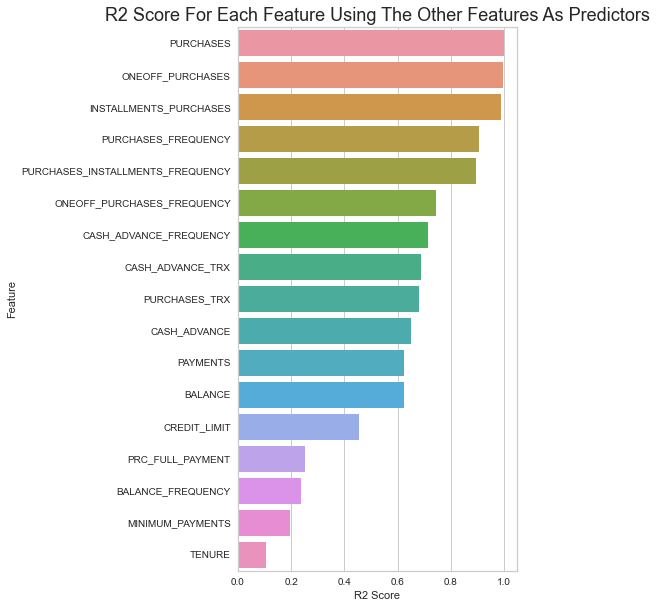

In [18]:
response_variable = []
r2score = []
residuals = pd.DataFrame()

for i in features:
    X = df_scaled[features]
    X = X.drop(i, axis=1)
    y = df_scaled[i]
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)
    score = r2_score(y, y_pred)
    
    residuals[i] = y - y_pred
    
    response_variable.append(i)
    r2score.append(score)

regression_results = pd.DataFrame({'Response_variable': response_variable
                                   , 'R2_Score': r2score})

regression_results.sort_values('R2_Score', ascending=False, inplace=True)
plt.figure(figsize=(5, 10))
sns.barplot(y = 'Response_variable',
            x = 'R2_Score',
            orient = 'h',
            data=regression_results)
plt.title('R2 Score For Each Feature Using The Other Features As Predictors', fontsize=18)
plt.xlabel('R2 Score')
plt.ylabel('Feature')
plt.show()

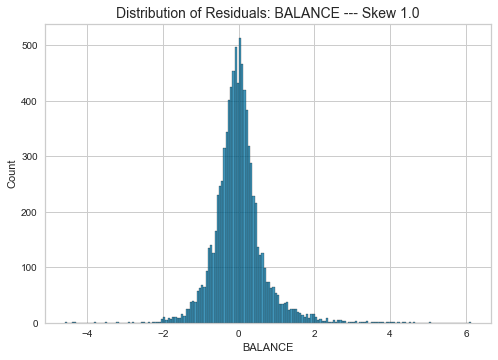

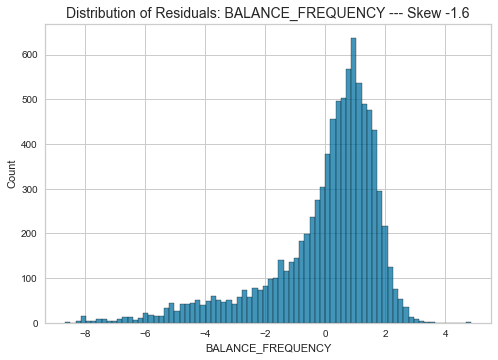

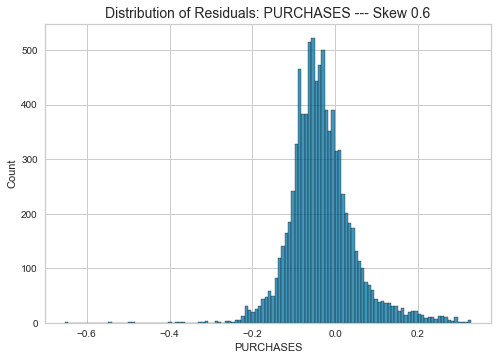

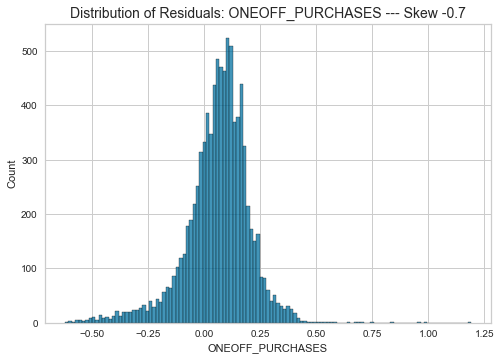

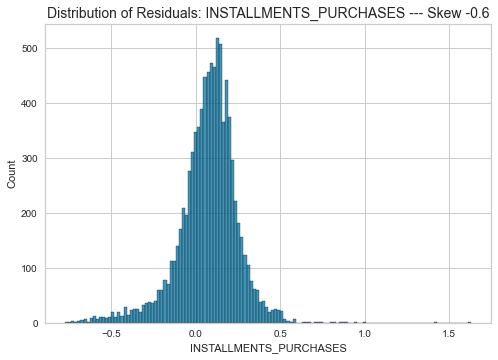

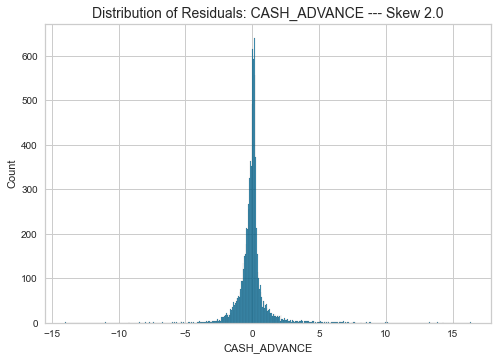

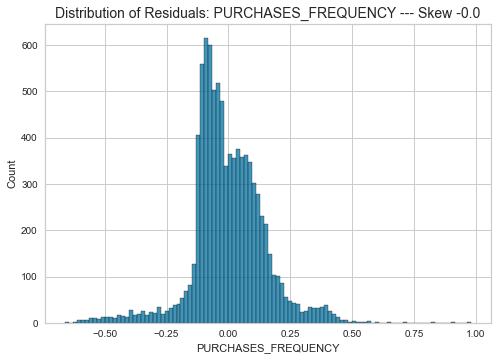

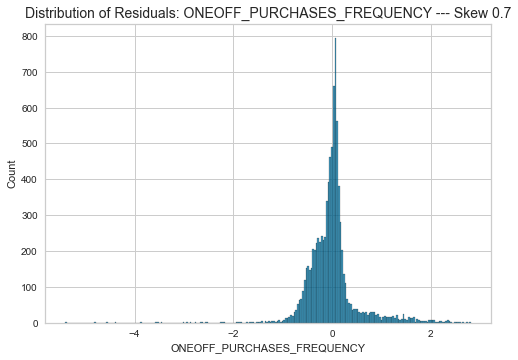

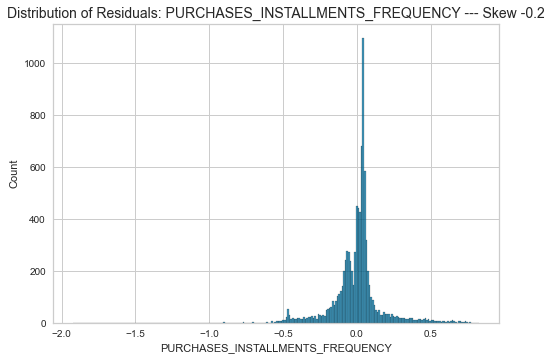

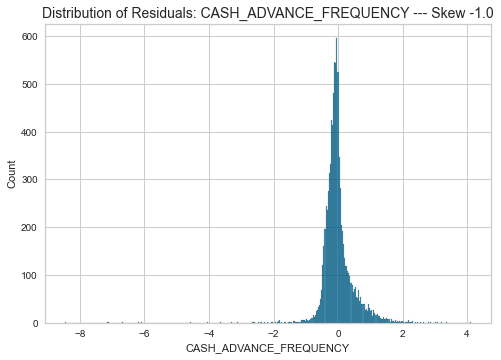

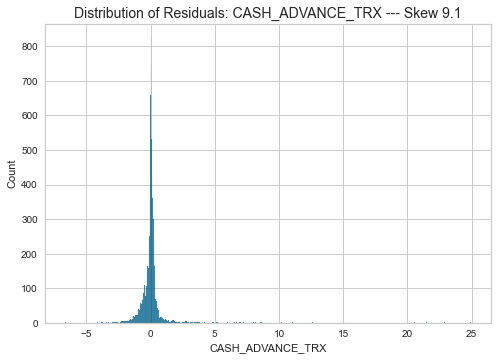

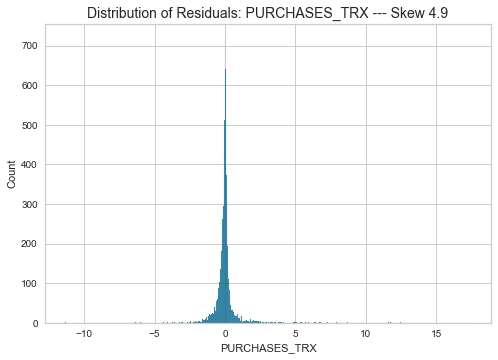

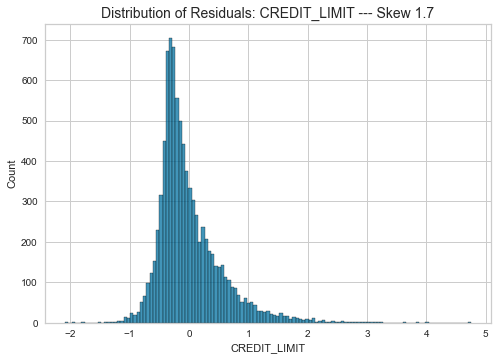

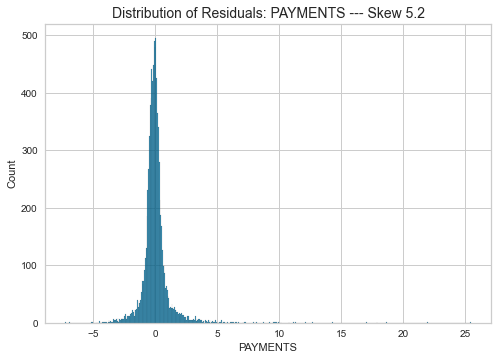

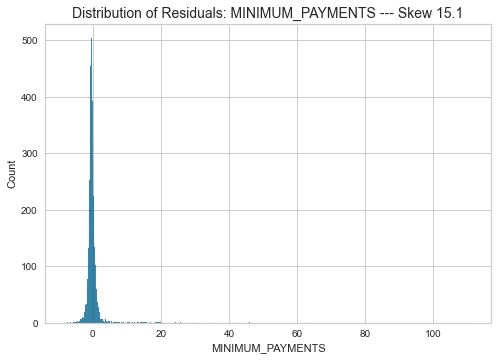

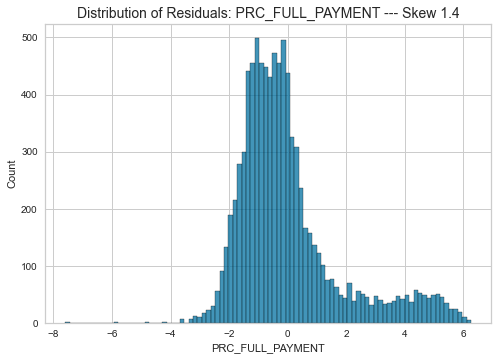

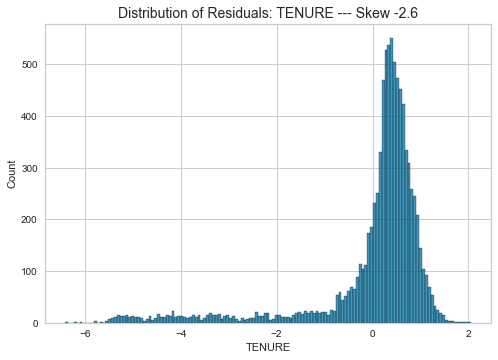

In [19]:
# Plot the distribution of the residuals
# (Multiple linear regression assumes that the residuals are normally distributed)
for i in residuals.columns:
    skew = round(residuals[i].skew(), 1)
    sns.histplot(residuals[i])
    plt.title('Distribution of Residuals: ' + str(i) + ' --- Skew ' + str(skew), fontsize=14)
    plt.show()

# Modeling <a class="anchor" id="modeling"></a>

## K-means clustering <a class="anchor" id="cluster"></a>

### Find optimal number of clusters <a class="anchor" id="elbow"></a>

Optimal number of clusters: 6


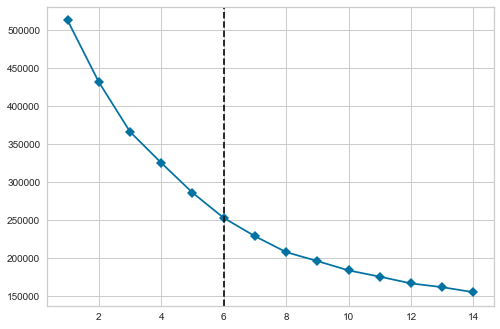

In [20]:
# Use the elbow method to choose the optimal number of clusters 
X = df_scaled[features]
kmeans = KMeans(random_state=1)
kmeans_vis = KElbowVisualizer(kmeans, k=(1,15), metric='distortion', timings=False).fit(X)
print('Optimal number of clusters:', kmeans_vis.elbow_value_)

### Cluster customers <a class="anchor" id="cluster_customers"></a>

In [21]:
# Cluster the customers using the optimal number of clusters
df_scaled['CLUSTERS'] = KMeans(n_clusters=kmeans_vis.elbow_value_, random_state=1).fit_predict(X)

# Count the number of customers in each cluster
count_clusters = df_scaled.groupby('CLUSTERS').agg({'CUST_ID': 'nunique'})
customers = df_scaled['CUST_ID'].nunique()
count_clusters['Percent_of_Customers'] = count_clusters['CUST_ID']/customers
count_clusters

,CUST_ID,Percent_of_Customers
CLUSTERS,,
0,749,0.083687
1,1209,0.135084
2,5466,0.610726
3,1465,0.163687
4,23,0.002570
5,38,0.004246


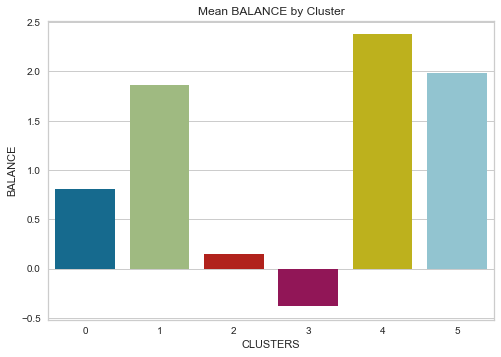

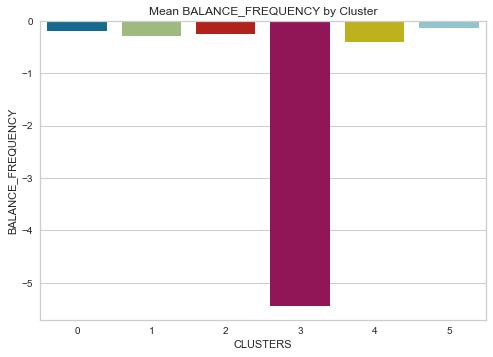

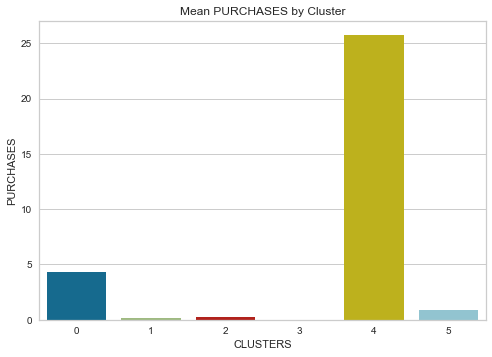

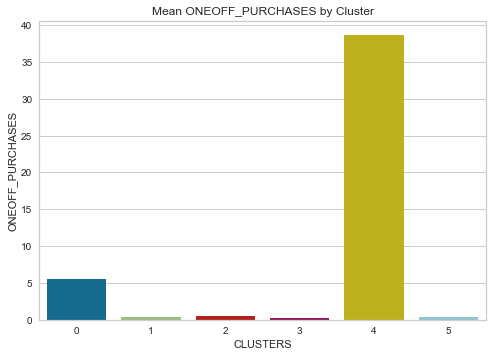

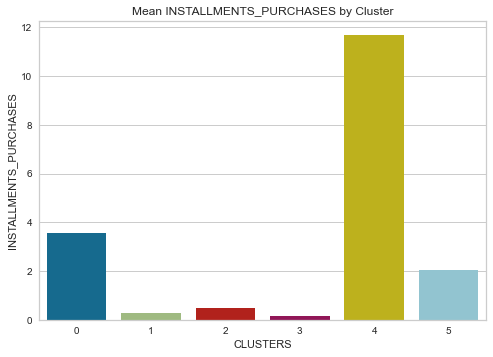

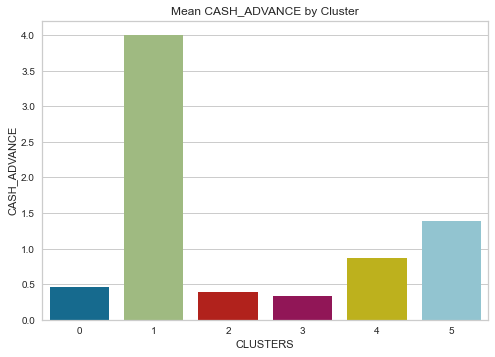

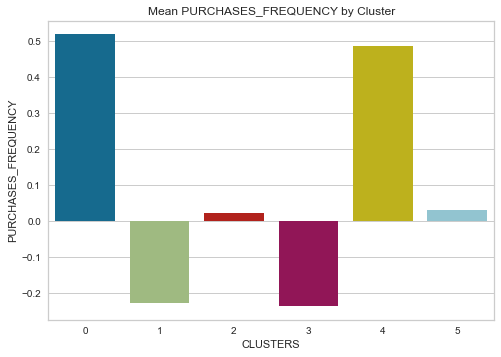

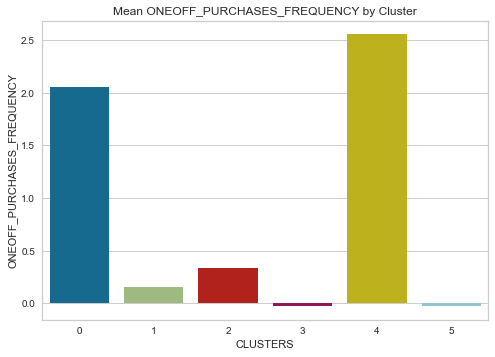

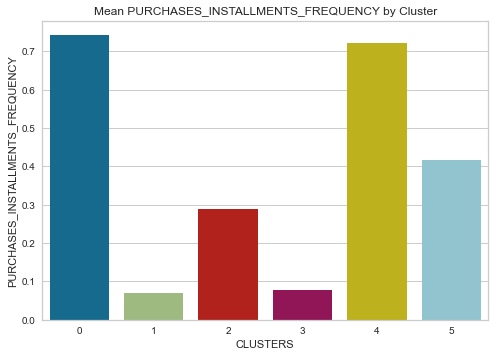

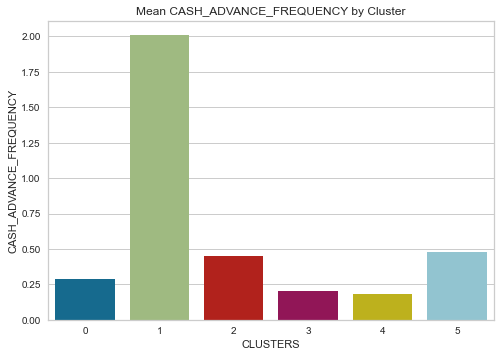

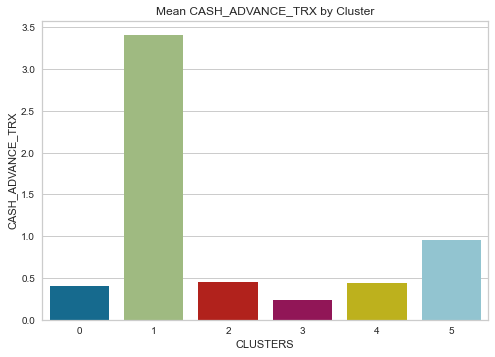

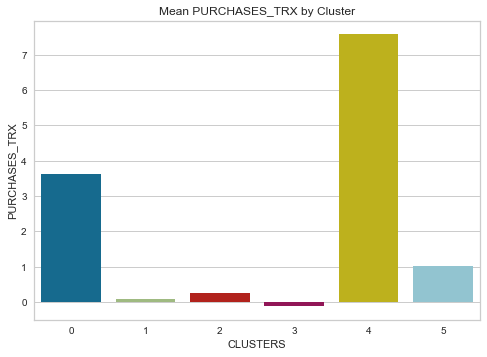

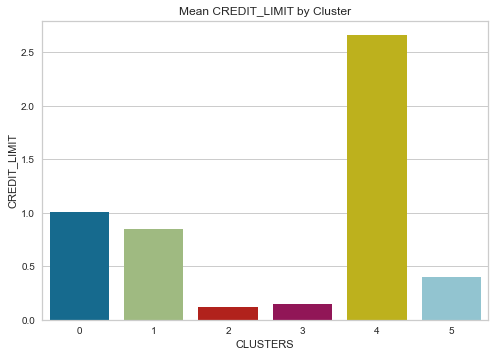

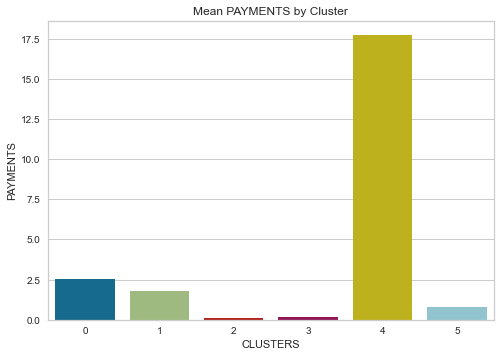

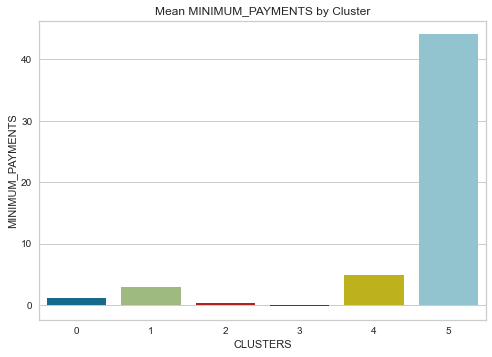

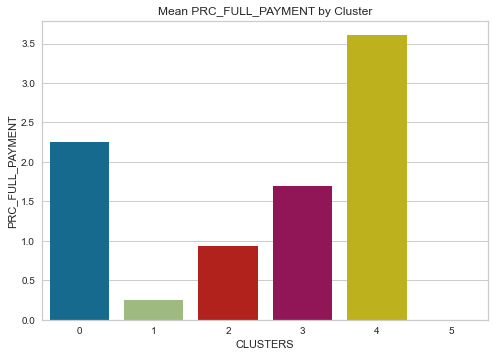

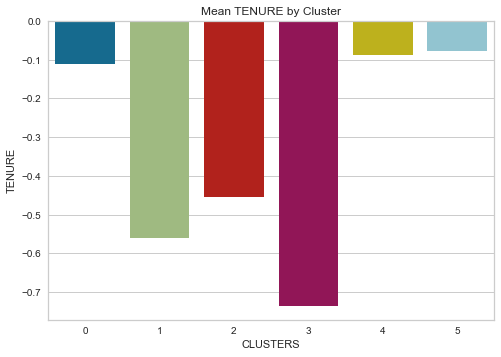

In [22]:
# Plot the average feature value for each cluster
describe_clusters = df_scaled.groupby('CLUSTERS').mean()

for i in features:
    sns.barplot(x = describe_clusters.index
               , y = i
               , data = describe_clusters)
    plt.title('Mean ' + str(i) + ' by Cluster')
    plt.show()

In [23]:
# Average feature value for each cluster
describe_clusters.transpose().style.background_gradient(cmap = 'RdYlGn')

CLUSTERS,0,1,2,3,4,5
BALANCE,0.807635,1.866129,0.142755,-0.382031,2.375469,1.983072
BALANCE_FREQUENCY,-0.186646,-0.291563,-0.258842,-5.436679,-0.394862,-0.129187
PURCHASES,4.337847,0.127790,0.244745,0.000270,25.740686,0.872005
ONEOFF_PURCHASES,5.571785,0.405386,0.481689,0.269139,38.649326,0.380966
INSTALLMENTS_PURCHASES,3.545487,0.292529,0.465997,0.169949,11.679051,2.022427
CASH_ADVANCE,0.457702,4.000455,0.388182,0.335697,0.870975,1.384748
PURCHASES_FREQUENCY,0.517180,-0.226416,0.021319,-0.236278,0.486087,0.030861
ONEOFF_PURCHASES_FREQUENCY,2.059739,0.149906,0.331815,-0.028370,2.555557,-0.026581
PURCHASES_INSTALLMENTS_FREQUENCY,0.742816,0.070592,0.287937,0.076471,0.722705,0.416533
CASH_ADVANCE_FREQUENCY,0.289947,2.009885,0.452029,0.206621,0.179348,0.479067


## SMOTE <a class="anchor" id="SMOTE"></a>
Since the clusters are not equally sized, use the synthetic minority oversampling technique (SMOTE) to oversample the smaller clusters.

In [24]:
# SMOTE
X = df_scaled[features]
y = df_scaled['CLUSTERS']

counter = Counter(y)
print('Before SMOTE:')
print(dict(sorted(counter.items())))
print('='*50)

oversample = SMOTE(random_state = 1)
X_SMOTE, y_SMOTE = oversample.fit_resample(X, y)

counter = Counter(y_SMOTE)
print('After SMOTE:')
print(dict(sorted(counter.items())))

df_scaled_SMOTE = pd.concat([y_SMOTE, X_SMOTE], axis=1)

Before SMOTE:
{0: 749, 1: 1209, 2: 5466, 3: 1465, 4: 23, 5: 38}
After SMOTE:
{0: 5466, 1: 5466, 2: 5466, 3: 5466, 4: 5466, 5: 5466}


## Model selection <a class="anchor" id="model_selection"></a>

### Decision tree classifier <a class="anchor" id="decision_tree"></a>

In [25]:
# Separate the feature and target variables
X = df_scaled_SMOTE[features]
y = df_scaled_SMOTE['CLUSTERS']

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

# Fit the decision tree with the training data
tree_model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)

# Predict test values
y_pred = tree_model.predict(X_test)

# Evaluate the model with accuracy on the test dataset
tree_accuracy = accuracy_score(y_test, y_pred)

# Classification report
print('Accuracy:', tree_accuracy)
print('Decision Tree Classifier')
print(classification_report(y_test, y_pred))

Accuracy: 0.9863254180911023
Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1804
           1       0.97      0.97      0.97      1804
           2       0.97      0.96      0.97      1803
           3       1.00      0.99      1.00      1804
           4       1.00      1.00      1.00      1804
           5       1.00      1.00      1.00      1804

    accuracy                           0.99     10823
   macro avg       0.99      0.99      0.99     10823
weighted avg       0.99      0.99      0.99     10823



### Multinomial logistic regression <a class="anchor" id="logistic_regression"></a>

In [26]:
# The multinomial logistic regression model assumes that the predicters are not strongly correlated with one another.
# Use the variance inflation factor (VIF) to check for multicollinearity
X = df_scaled_SMOTE[features]

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Create list of features with a VIF >= 10
high_vif = list(vif[vif["VIF"] >= 10]["feature"])

# Remove features with a high VIF
remove_high_vif = [x for x in features if x not in high_vif]

vif.sort_values("VIF", ascending=False)

,feature,VIF
2,PURCHASES,22154.233373
3,ONEOFF_PURCHASES,14878.405001
4,INSTALLMENTS_PURCHASES,1509.166734
13,PAYMENTS,18.207210
8,PURCHASES_INSTALLMENTS_FREQUENCY,11.842262
6,PURCHASES_FREQUENCY,10.131504
7,ONEOFF_PURCHASES_FREQUENCY,7.413021
9,CASH_ADVANCE_FREQUENCY,6.457256
12,CREDIT_LIMIT,5.538454
11,PURCHASES_TRX,5.317824


In [27]:
# Multinomial logistic regression

# Separate the feature and target variables
X = df_scaled_SMOTE[remove_high_vif]
X = sm.add_constant(X)
y = df_scaled_SMOTE['CLUSTERS']

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

# Fit the logistic model with the training data
logit_model = LogisticRegression(random_state=1, solver='liblinear').fit(X_train, y_train)

# Predict test values
y_pred = logit_model.predict(X_test)

# Evaluate the model with accuracy on the test dataset
MNLogit_accuracy = accuracy_score(y_test, y_pred)

# Classification report
print('Accuracy:', MNLogit_accuracy)
print('Multinomial Logistic Regression')
print(classification_report(y_test, y_pred))

Accuracy: 0.8985493855677723
Multinomial Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.71      0.75      1804
           1       0.88      0.91      0.90      1804
           2       0.86      0.83      0.85      1803
           3       0.96      1.00      0.98      1804
           4       0.89      0.94      0.92      1804
           5       0.98      1.00      0.99      1804

    accuracy                           0.90     10823
   macro avg       0.90      0.90      0.90     10823
weighted avg       0.90      0.90      0.90     10823



# The decision tree is more accurate than the logistic model.

### Optimize decision tree hyperparamters

Text(0.5, 1.0, 'Max Depth of Decision Tree and its Accuracy')

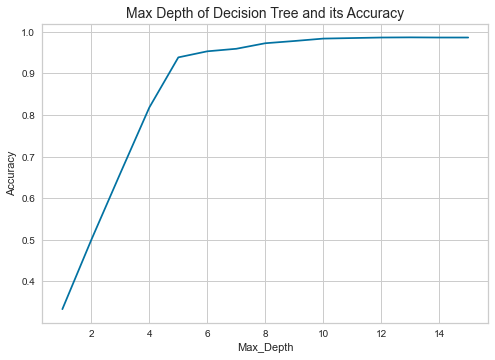

In [28]:
# Max depth of the decision tree classifier
X = df_scaled_SMOTE[features]
y = df_scaled_SMOTE['CLUSTERS']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)

acc = []
depth = []
for i in range(1, 16):
    tree_model = DecisionTreeClassifier(random_state=1, max_depth=i).fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)
    tree_accuracy = accuracy_score(y_test, y_pred)
    acc.append(tree_accuracy)
    depth.append(i)

tree_depth = pd.DataFrame({'Max_Depth': depth
                          , 'Accuracy': acc})
sns.lineplot(x = 'Max_Depth'
            , y = 'Accuracy'
            , data = tree_depth)
plt.title('Max Depth of Decision Tree and its Accuracy', fontsize=14)

In [29]:
# The accuracy stops improving when the tree depth is greater than 10
# Fit decision tree with the optimal max depth
optimal_max_depth = 10

X = df_scaled_SMOTE[features]
y = df_scaled_SMOTE['CLUSTERS']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=1)
tree_model = DecisionTreeClassifier(random_state=1, max_depth=optimal_max_depth).fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', tree_accuracy)

Accuracy: 0.9839231266746743


## Feature importance <a class="anchor" id="feature_importance"></a>

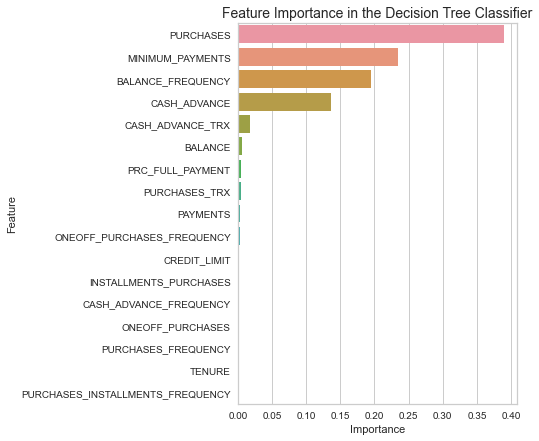

In [30]:
tree_importance = pd.DataFrame({'Feature': features
                               , 'Importance': tree_model.feature_importances_})

tree_importance.sort_values('Importance', ascending=False, inplace=True)

plt.figure(figsize=(5, 7))
sns.barplot(y = 'Feature',
            x = 'Importance',
            orient = 'h',
            data=tree_importance)
plt.title('Feature Importance in the Decision Tree Classifier', fontsize=14)
plt.show()

Text(0.5, 1.0, 'Distribution of PURCHASES by CLUSTER')

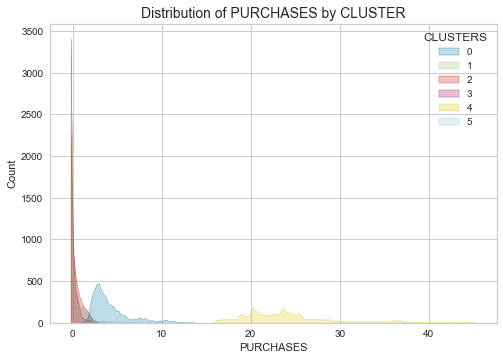

In [31]:
# PURCHASES is the most important feature, plot its distribution for each cluster
unique = sorted(df_scaled_SMOTE.CLUSTERS.unique())
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))

sns.histplot(x = 'PURCHASES'
            , hue = 'CLUSTERS'
             , element = 'poly'
             , palette = palette
            , data = df_scaled_SMOTE)
plt.title('Distribution of PURCHASES by CLUSTER', fontsize=14)

## Visualize decision tree <a class="anchor" id="visualize"></a>

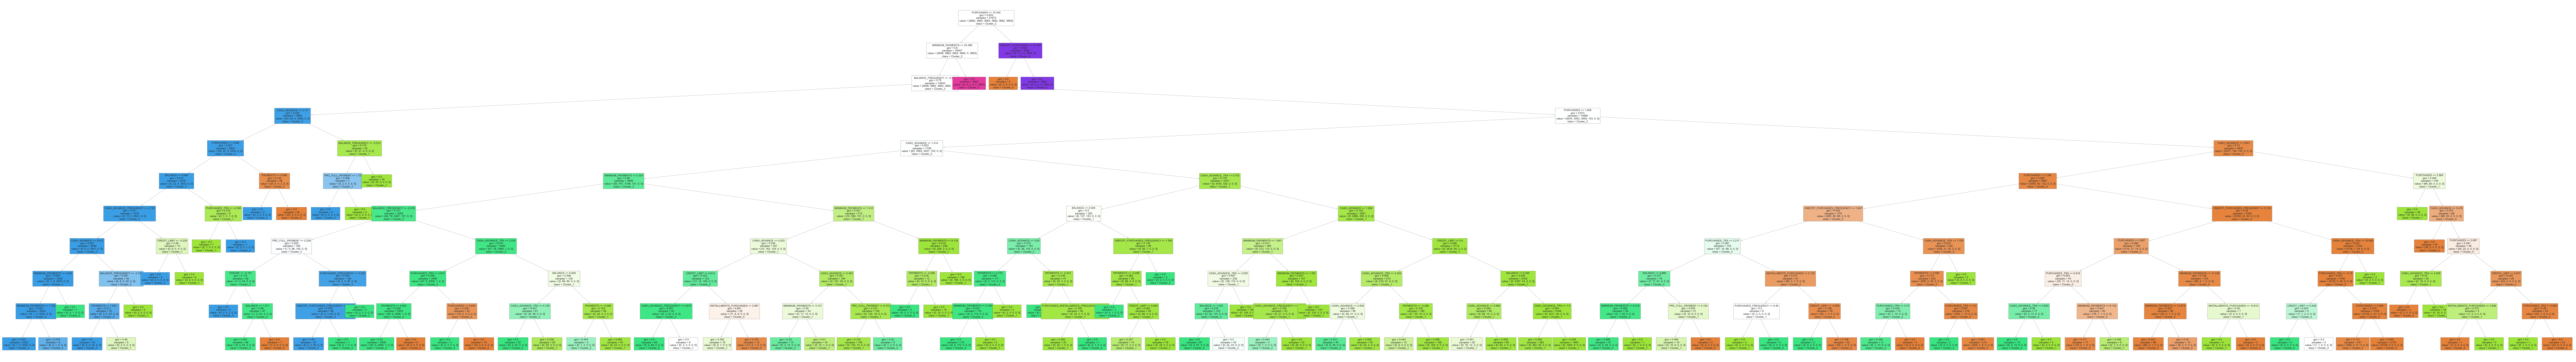

In [32]:
targets = sorted(df_scaled_SMOTE['CLUSTERS'].unique())
targets = ['Cluster_' + str(x) for x in targets]

plt.figure(figsize=(175, 25))
plot_tree(tree_model
          , feature_names = features
          , class_names = targets
          , filled = True
          , fontsize = 10)

plt.savefig('customer_segmentation_decision_tree.jpg')
plt.show()

# Summarize insights from analysis <a class="anchor" id="summary"></a>

In [33]:
def summarize_clusters(cluster):
    """Returns description of cluster"""
    counter = Counter(cluster)
    counter = dict(sorted(counter.items()))
    summary = dict()
    for i in counter.keys():
        if counter[i] >= 5400:
            summary[i] = ['Average credit card customer (each of their features are within one standard deviation from the mean)', 'Not the highest or lowest for any feature']
        elif counter[i] >= 1400:
            summary[i] = ['Lowest number of transactions made with cash in advanced'
                                , 'Lowest amount of cash in advance transactions'
                                , 'Lowest number of purchases'
                                , 'Lowest amount of purchases'
                                , 'Lowest amount purchases done in installment'
                                , 'Lowest balance frequency'
                                , 'Lowest balance amount left in their account to make purchases'
                                , 'Lowest tenure'
                                , 'Lowest credit card limit'
                                , 'Lowest amount of minimum payments']
        elif counter[i] >= 1190:
            summary[i] = ['Highest number of transactions made with cash in advanced'
                                , 'Highest amount of cash in advance transactions'
                                , 'Highest frequency of cash in advance transactions'
                                , 'High amount of minimum payments'
                                , 'Low tenure'
                                , 'Low balance frequency'
                                , 'Low purchase freqency']
        elif counter[i] >= 700:
            summary[i] = ['High number of purchases'
                                , 'High amount of purchases'
                                , 'High amount of purchases done in installment'
                                , 'High amount of one-off purchases'
                                , 'High frequency of one-off purchases'
                                , 'High amount of payments'
                                , 'High amount of full payments']
        elif counter[i] >= 30:
            summary[i] = ['Highest balance frequency'
                                , 'Highest tenure'
                                , 'Highest amount of minimum payments'
                                , 'Lowest amount of full payments'
                                , 'Lowest amount of one-off purchases'
                                , 'Lowest frequency of one-off purchases']
        else:
            summary[i] = ['Highest number of purchases'
                                , 'Highest amount of purchases'
                                , 'Highest frequency of purchases'
                                , 'Highest amount of one-off purchases'
                                , 'Highest frequency of one-off purchases'
                                , 'Highest amount of purchases done in installment'
                                , 'Highest amount of payments'
                                , 'Highest amount of full payments'
                                , 'Highest credit limit'
                                , 'Highest balance amount left in their account to make purchases'
                                , 'Lowest frequency of cash in advance transactions']
    for i in summary.keys():
        print('Cluster:', i)
        print(summary[i])
        print('-'*100)


clusters = df_scaled['CLUSTERS']
summarize_clusters(clusters)

Cluster: 0
['High number of purchases', 'High amount of purchases', 'High amount of purchases done in installment', 'High amount of one-off purchases', 'High frequency of one-off purchases', 'High amount of payments', 'High amount of full payments']
----------------------------------------------------------------------------------------------------
Cluster: 1
['Highest number of transactions made with cash in advanced', 'Highest amount of cash in advance transactions', 'Highest frequency of cash in advance transactions', 'High amount of minimum payments', 'Low tenure', 'Low balance frequency', 'Low purchase freqency']
----------------------------------------------------------------------------------------------------
Cluster: 2
['Average credit card customer (each of their features are within one standard deviation from the mean)', 'Not the highest or lowest for any feature']
----------------------------------------------------------------------------------------------------
Cluster: 3